/tmp/ipykernel_25424/3594851023.py:508: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prefix_counts.index, y=prefix_counts.values, palette="viridis")


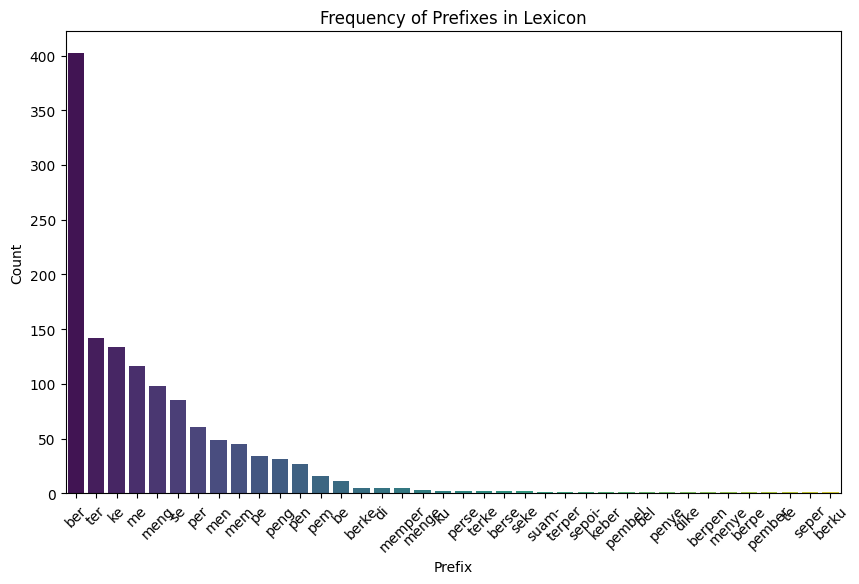

/tmp/ipykernel_25424/3594851023.py:523: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suffix_counts.index, y=suffix_counts.values, palette="magma")


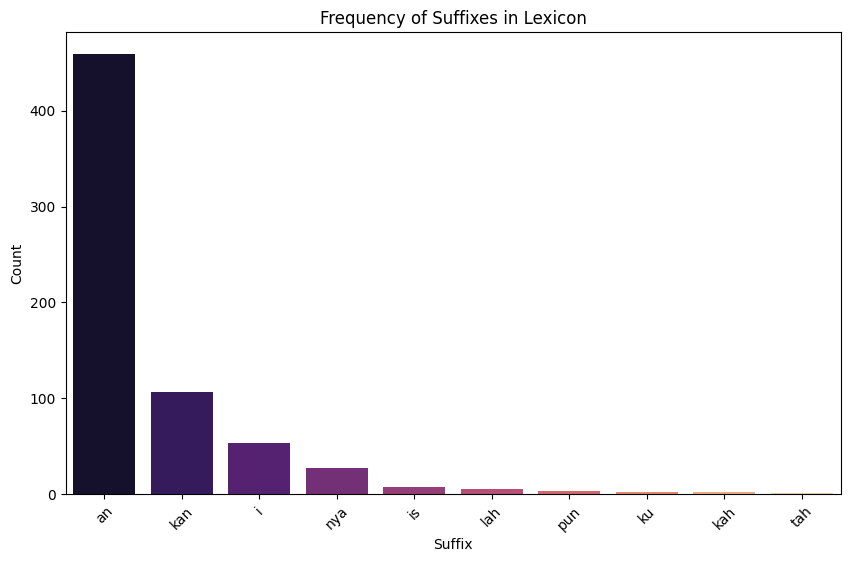

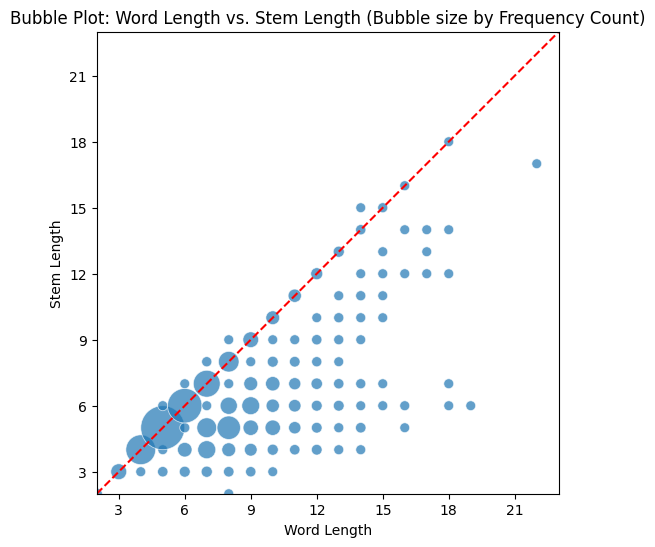

Last Analysis Result Received Time:  2024-12-18 13:35:05


In [31]:
# Available Topics correspond to the ploting function:
# ("lemma_length_analysis",plot_lemma_length)
# ("word_length_analysis",plot_word_length)
# ("lexicon_analysis", plot_lexicon_analysis)
# ("sentiment_dist_analysis",plot_sentiment_dist)
# ("word_freq_with_stopwords",plot_word_freq_with_stopwords)
# ("word_freq_without_stopwords",plot_word_freq_without_stopwords)
# ("POSDistribution",plot_POS_distribution)
# ("morphological_analysis",plot_morphological)

AnalysisVisualization.visualize_analysis_topic("morphological_analysis", AnalysisVisualization.plot_morphological, False, 'localhost:9092', 0)

In [39]:
message = AnalysisVisualization.get_kafka_topic_latest_message("POSDistribution",'localhost:9092', 0)
print(message.value)

[{'pos': 'Proper noun', 'total_count': 5135}, {'pos': 'Noun', 'total_count': 120}, {'pos': 'Adposition', 'total_count': 15}, {'pos': 'Number', 'total_count': 6}]


In [37]:
import time
import json
import matplotlib.pyplot as plt
from kafka import KafkaConsumer, TopicPartition
from IPython.display import display, clear_output
import seaborn as sns
import pandas as pd
from datetime import datetime
import traceback

class AnalysisVisualization:
    @staticmethod
    def get_kafka_topic_latest_message(topics, bootstrap_servers, kafka_partition):
        topic = topics
        bootstrap_servers = bootstrap_servers
        partition = kafka_partition
        consumer = KafkaConsumer(
            bootstrap_servers=bootstrap_servers,
            value_deserializer=lambda x: json.loads(x.decode('utf-8'))
        )
        topic_partition = TopicPartition(topic, partition)
        consumer.assign([topic_partition])
        consumer.seek_to_end(topic_partition)
        latest_offset = consumer.position(topic_partition)

        consumer.seek(topic_partition, latest_offset - 1)
        new_message = None
        for message in consumer:
            new_message = message
            break  
        consumer.close()

        if new_message == None:
            return None
        else:
            # if topic == "morphological_analysis":
            #     result = json.loads(new_message.value)
            #     df_received = pd.DataFrame(result)
            #     return df_received
            return new_message
            

        
    
    @staticmethod
    def visualize_analysis_topic(topics, plot_func, auto_update, bootstrap_servers, kafka_partition):
        topic = topics
        bootstrap_servers = bootstrap_servers
        partition = kafka_partition
        consumer = KafkaConsumer(
            bootstrap_servers=bootstrap_servers,
            value_deserializer=lambda x: json.loads(x.decode('utf-8'))
        )
        topic_partition = TopicPartition(topic, partition)
        consumer.assign([topic_partition])
        consumer.seek_to_end(topic_partition)
        latest_offset = consumer.position(topic_partition)

        try:
            consumer.seek(topic_partition, latest_offset - 1)
            new_message = None
            for message in consumer:
                new_message = message
                break  
            consumer.close()

            if topic == "morphological_analysis":
                result = json.loads(new_message.value)
                df_received = pd.DataFrame(result)
                plot_func(df_received)
            else:
                plot_func(new_message.value)
                
            last_message_timestamp = datetime.fromtimestamp(new_message.timestamp / 1000)
            print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
        except Exception as ex:
            print(f"There is no analysis result for topic \"{topic}\" yet. or error occur when plotting the function")
            print("Last Updated: ", datetime.now())
            print("An error occurred:", ex)
            traceback.print_exc()
            pass

        if auto_update:
            # Keep listening for new messages and update the plot
            consumer = KafkaConsumer(topic, bootstrap_servers=bootstrap_servers, value_deserializer=lambda x: json.loads(x.decode('utf-8')))
            for message in consumer:
                plot_func(message.value)
                last_message_timestamp = datetime.fromtimestamp(message.timestamp / 1000)
                print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    
   
    @staticmethod
    def plot_lemma_length(message):
        clear_output(wait=True)
        word_lengths = message["word_lengths"]
        average_word_length = message["avg_word_length"]
        most_freq_length = message["most_freq_length"]
        max_word_length = max(word_lengths)
        min_word_length = min(word_lengths)
        bins = max_word_length - min_word_length
        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(word_lengths, kde=True, color='blue', bins=int(bins), ax=ax)
        ax.set_title(f'Distribution of Base Word Lengths (Avg = {average_word_length:.2f} Most Freq. Length = {most_freq_length})')
        ax.set_xlabel('Base Word Length')
        ax.set_ylabel('Frequency')
        display(plt.gcf())

    @staticmethod
    def plot_word_length(message):
        # Clear the output before rendering a new plot
        clear_output(wait=True)
        word_lengths = message["word_lengths"]
        average_word_length = message["avg_word_length"]
        most_freq_length = message["most_freq_length"]
        max_word_length = max(word_lengths)
        min_word_length = min(word_lengths)
        bins = max_word_length - min_word_length
        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(word_lengths, kde=True, color='green', bins=int(bins), ax=ax)
        ax.set_title(f'Distribution of Word Lengths (Avg = {average_word_length:.2f} Most Freq. Length = {most_freq_length})')
        ax.set_xlabel('Word Length')
        ax.set_ylabel('Frequency')
        display(plt.gcf())
        plt.close()


    @staticmethod
    def plot_lexicon_analysis(result):
        clear_output(wait=True)
        total_words = result[0]['totalWords']
        total_peri = result[0]['totalPeri']
        
        # Plot
        labels = ['totalWords', 'totalPeri']
        values = [total_words, total_peri]
        
        # Set up the plot
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x=labels, y=values, palette='viridis')
        
        # Add text on top of each bar
        for i, value in enumerate(values):
            ax.text(i, value + 50, str(value), ha='center', va='bottom', fontsize=12)  # Adjust 'value + 50' for positioning
        
        # Title and labels
        plt.title('Comparison of totalWords and totalPeri')
        plt.ylabel('Count')
        plt.xlabel('Category')

        # Display the plot
        display(plt.gcf())
        plt.close()


    @staticmethod
    def plot_sentiment_dist(result):
        clear_output(wait=True)
        pos = [item['label'] for item in result]
        counts = [item['total_count'] for item in result]
        # Visualization 1: Sentiment Distribution Pie Chart
        plt.figure(figsize=(8, 8))
        plt.pie(
            counts,
            labels=pos,
            autopct='%1.1f%%',
            startangle=140,
            colors=sns.color_palette('pastel')
        )
        plt.title('Sentiment Distribution')
        plt.show()
        
        # Visualization 2: Sentiment Distribution Bar Chart
        plt.figure(figsize=(10, 6))
        sns.barplot(x=pos, y=counts, palette="coolwarm")
        plt.title('Frequency of Sentiment Labels')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        display(plt.gcf())
        plt.close()
        

    @staticmethod
    def plot_word_freq_with_stopwords(result):
        clear_output(wait=True)
        words = [item['word'] for item in result]
        counts = [item['count'] for item in result]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=words, y=counts, palette="viridis")
        plt.xlabel("Words")
        plt.ylabel("Count")
        plt.title("Top Words and Their Counts")
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
        plt.tight_layout()  # Adjust layout to fit labels
        display(plt.gcf())
        plt.close()


    @staticmethod
    def plot_word_freq_without_stopwords(top_15_result):
        clear_output(wait=True)
        words = [item['word'] for item in top_15_result]
        counts = [item['count'] for item in top_15_result]
        
        # bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x=words, y=counts, palette="viridis")
        plt.xlabel("Words")
        plt.ylabel("Count")
        plt.title("Top Words and Their Counts")
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
        plt.tight_layout()  # Adjust layout to fit labels
        display(plt.gcf())
        plt.close()


    @staticmethod
    def plot_POS_distribution(result):
        clear_output(wait=True)
        pos = [item['pos'] for item in result]
        counts = [item['total_count'] for item in result]
        #bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(pos, counts, color='skyblue')
        
        # Add labels and title
        plt.xlabel('Part of Speech Distribution')
        plt.ylabel('Total Count')
        plt.title('Word Count by Part of Speech')
        plt.xticks(rotation=45)  # Rotate x labels for better readability
        
        # Show the plot
        plt.tight_layout()  # Adjust layout to avoid clipping
        display(plt.gcf())
        plt.close()

    @staticmethod
    def plot_morphological(df_result):
        clear_output(wait=True)
    
        # Prefix Visualization
        df_prefix = df_result['prefix'].str.strip()
        df_prefix = df_prefix[df_prefix != '']
        prefix_counts = df_prefix.dropna().value_counts()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=prefix_counts.index, y=prefix_counts.values, palette="viridis")
        plt.title('Frequency of Prefixes in Lexicon')
        plt.xlabel('Prefix')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        display(plt.gcf())
        plt.close()  # Close the figure after displaying to prevent overlap
        
        # Suffix Visualization
        df_suffix = df_result['suffix'].str.strip()
        df_suffix = df_suffix.apply(lambda x: None if isinstance(x, str) and x.startswith('-') else x)
        df_suffix = df_suffix[df_suffix != '']
        suffix_counts = df_suffix.dropna().value_counts()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=suffix_counts.index, y=suffix_counts.values, palette="magma")
        plt.title('Frequency of Suffixes in Lexicon')
        plt.xlabel('Suffix')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        display(plt.gcf())
        plt.close()
        
        # Word Length vs. Stem Length Visualization
        word_length = df_result['word'].str.len()
        stem_length = df_result['stem'].str.len()
        
        data = {
            'word_length': word_length,
            'stem_length': stem_length,
        }
        df_counts = pd.DataFrame(data)
        count_data = df_counts.groupby(['word_length', 'stem_length']).size().reset_index(name='count')
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x='word_length',
            y='stem_length',
            size='count',
            sizes=(50, 1000),
            data=count_data,
            alpha=0.7,
            legend=False
        )
        max_value = max(count_data['word_length'].max(), count_data['stem_length'].max()) + 1
        plt.plot([2, max_value], [2, max_value], color='r', linestyle='--')
        plt.xlim(0, max_value)
        plt.ylim(0, max_value)
        plt.xlim(left=2)
        plt.ylim(bottom=2)
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Bubble Plot: Word Length vs. Stem Length (Bubble size by Frequency Count)')
        plt.xlabel('Word Length')
        plt.ylabel('Stem Length')
        display(plt.gcf())
        plt.close()

    # @staticmethod
    # def lemma_length(auto_update):
    #     topic = "lemma_length_analysis"
    #     bootstrap_servers = 'localhost:9092'
    #     partition = 0
    #     consumer = KafkaConsumer(
    #         bootstrap_servers=bootstrap_servers,
    #         value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    #     )
    #     topic_partition = TopicPartition(topic, partition)
    #     consumer.assign([topic_partition])
    #     consumer.seek_to_end(topic_partition)
    #     latest_offset = consumer.position(topic_partition)

    #     try:
    #         consumer.seek(topic_partition, latest_offset - 1)
    #         new_message = None
    #         for message in consumer:
    #             new_message = message
    #             break  
    #         consumer.close()
    #         AnalysisVisualization.plot_lemma_length(new_message.value)
    #         last_message_timestamp = datetime.fromtimestamp(new_message.timestamp / 1000)
    #         print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    #     except:
    #         print("There is no analysis result yet.")
    #         print("Last Updated: ", datetime.now())
    #         pass

    #     if auto_update:
    #         # Keep listening for new messages and update the plot
    #         consumer = KafkaConsumer(topic, bootstrap_servers=bootstrap_servers, value_deserializer=lambda x: json.loads(x.decode('utf-8')))
    #         for message in consumer:
    #             AnalysisVisualization.plot_lemma_length(message.value)
    #             last_message_timestamp = datetime.fromtimestamp(message.timestamp / 1000)
    #             print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))

        
    # @staticmethod
    # def word_length(auto_update):
    #     topic = "word_length_analysis"
    #     bootstrap_servers = 'localhost:9092'
    #     partition = 0
    #     consumer = KafkaConsumer(
    #         bootstrap_servers=bootstrap_servers,
    #         value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    #     )
    #     topic_partition = TopicPartition(topic, partition)
    #     consumer.assign([topic_partition])
    #     consumer.seek_to_end(topic_partition)
    #     latest_offset = consumer.position(topic_partition)
    #     try:
    #         consumer.seek(topic_partition, latest_offset - 1)
    #         new_message = None
    #         for message in consumer:
    #             new_message = message
    #             break  
    #         consumer.close()
    #         AnalysisVisualization.plot_word_length(new_message.value)
    #         last_message_timestamp = datetime.fromtimestamp(new_message.timestamp / 1000)
    #         print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    #     except:
    #         print("There is no analysis result yet.")
    #         print("Last Updated: ", datetime.now())
    #         pass
            
    #     if auto_update:
    #         # Keep listening for new messages and update the plot
    #         consumer = KafkaConsumer(topic, bootstrap_servers=bootstrap_servers, value_deserializer=lambda x: json.loads(x.decode('utf-8')))
    #         for message in consumer:
    #             AnalysisVisualization.plot_word_length(message.value)
    #             last_message_timestamp = datetime.fromtimestamp(message.timestamp / 1000)
    #             print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))


    # @staticmethod
    # def lexicon_analysis(auto_update):
    #     topic = "lexicon_analysis"
    #     bootstrap_servers = 'localhost:9092'
    #     partition = 0
    #     consumer = KafkaConsumer(
    #         bootstrap_servers=bootstrap_servers,
    #         value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    #     )
    #     topic_partition = TopicPartition(topic, partition)
    #     consumer.assign([topic_partition])
    #     consumer.seek_to_end(topic_partition)
    #     latest_offset = consumer.position(topic_partition)
    #     try:
    #         consumer.seek(topic_partition, latest_offset - 1)
    #         new_message = None
    #         for message in consumer:
    #             print(message.offset)
    #             new_message = message
    #             break  
    #         consumer.close()
    #         AnalysisVisualization.plot_lexicon_analysis(new_message.value)
    #         last_message_timestamp = datetime.fromtimestamp(new_message.timestamp / 1000)
    #         print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    #     except:
    #         print("There is no analysis result yet.")
    #         print("Last Updated: ", datetime.now())
    #         pass
            
    #     if auto_update:
    #         # Keep listening for new messages and update the plot
    #         consumer = KafkaConsumer(topic, bootstrap_servers=bootstrap_servers, value_deserializer=lambda x: json.loads(x.decode('utf-8')))
    #         for message in consumer:
    #             AnalysisVisualization.plot_lexicon_analysis(message.value)
    #             last_message_timestamp = datetime.fromtimestamp(message.timestamp / 1000)
    #             print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
                

        
    # @staticmethod
    # def sentiment_dist(auto_update):
    #     topic = "sentiment_dist_analysis"
    #     bootstrap_servers = 'localhost:9092'
    #     partition = 0
    #     consumer = KafkaConsumer(
    #         bootstrap_servers=bootstrap_servers,
    #         value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    #     )
    #     topic_partition = TopicPartition(topic, partition)
    #     consumer.assign([topic_partition])
    #     consumer.seek_to_end(topic_partition)
    #     latest_offset = consumer.position(topic_partition)
    #     try:
    #         consumer.seek(topic_partition, latest_offset - 1)
    #         new_message = None
    #         for message in consumer:
    #             print(message.offset)
    #             new_message = message
    #             break  
    #         consumer.close()
    #         AnalysisVisualization.plot_sentiment_dist(new_message.value)
    #         last_message_timestamp = datetime.fromtimestamp(new_message.timestamp / 1000)
    #         print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    #     except:
    #         print("There is no analysis result yet.")
    #         print("Last Updated: ", datetime.now())
    #         pass
            
    #     if auto_update:
    #         # Keep listening for new messages and update the plot
    #         consumer = KafkaConsumer(topic, bootstrap_servers=bootstrap_servers, value_deserializer=lambda x: json.loads(x.decode('utf-8')))
    #         for message in consumer:
    #             AnalysisVisualization.plot_sentiment_dist(message.value)
    #             last_message_timestamp = datetime.fromtimestamp(message.timestamp / 1000)
    #             print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    

    # @staticmethod
    # def word_freq_with_stopwords(auto_update):
    #     topic = "word_freq_with_stopwords"
    #     bootstrap_servers = 'localhost:9092'
    #     partition = 0
    #     consumer = KafkaConsumer(
    #         bootstrap_servers=bootstrap_servers,
    #         value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    #     )
    #     topic_partition = TopicPartition(topic, partition)
    #     consumer.assign([topic_partition])
    #     consumer.seek_to_end(topic_partition)
    #     latest_offset = consumer.position(topic_partition)
    #     try:
    #         consumer.seek(topic_partition, latest_offset - 1)
    #         new_message = None
    #         for message in consumer:
    #             print(message.offset)
    #             new_message = message
    #             break  
    #         consumer.close()
    #         AnalysisVisualization.plot_word_freq_with_stopwords(new_message.value)
    #         last_message_timestamp = datetime.fromtimestamp(new_message.timestamp / 1000)
    #         print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    #     except:
    #         print("There is no analysis result yet.")
    #         print("Last Updated: ", datetime.now())
    #         pass
            
    #     if auto_update:
    #         # Keep listening for new messages and update the plot
    #         consumer = KafkaConsumer(topic, bootstrap_servers=bootstrap_servers, value_deserializer=lambda x: json.loads(x.decode('utf-8')))
    #         for message in consumer:
    #             AnalysisVisualization.plot_word_freq_with_stopwords(message.value)
    #             last_message_timestamp = datetime.fromtimestamp(message.timestamp / 1000)
    #             print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
                

    # @staticmethod
    # def word_freq_without_stopwords(auto_update):
    #     topic = "word_freq_without_stopwords"
    #     bootstrap_servers = 'localhost:9092'
    #     partition = 0
    #     consumer = KafkaConsumer(
    #         bootstrap_servers=bootstrap_servers,
    #         value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    #     )
    #     topic_partition = TopicPartition(topic, partition)
    #     consumer.assign([topic_partition])
    #     consumer.seek_to_end(topic_partition)
    #     latest_offset = consumer.position(topic_partition)
    #     try:
    #         consumer.seek(topic_partition, latest_offset - 1)
    #         new_message = None
    #         for message in consumer:
    #             print(message.offset)
    #             new_message = message
    #             break  
    #         consumer.close()
    #         AnalysisVisualization.plot_word_freq_without_stopwords(new_message.value)
    #         last_message_timestamp = datetime.fromtimestamp(new_message.timestamp / 1000)
    #         print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    #     except:
    #         print("There is no analysis result yet.")
    #         print("Last Updated: ", datetime.now())
    #         pass
            
    #     if auto_update:
    #         # Keep listening for new messages and update the plot
    #         consumer = KafkaConsumer(topic, bootstrap_servers=bootstrap_servers, value_deserializer=lambda x: json.loads(x.decode('utf-8')))
    #         for message in consumer:
    #             AnalysisVisualization.plot_word_freq_without_stopwords(message.value)
    #             last_message_timestamp = datetime.fromtimestamp(message.timestamp / 1000)
    #             print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
                
    
    
    # @staticmethod
    # def POS_distribution(auto_update):
    #     topic = "POSDistribution"
    #     bootstrap_servers = 'localhost:9092'
    #     partition = 0
    #     consumer = KafkaConsumer(
    #         bootstrap_servers=bootstrap_servers,
    #         value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    #     )
    #     topic_partition = TopicPartition(topic, partition)
    #     consumer.assign([topic_partition])
    #     consumer.seek_to_end(topic_partition)
    #     latest_offset = consumer.position(topic_partition)
    #     try:
    #         consumer.seek(topic_partition, latest_offset - 1)
    #         new_message = None
    #         for message in consumer:
    #             print(message.offset)
    #             new_message = message
    #             break  
    #         consumer.close()
    #         AnalysisVisualization.plot_POS_distribution(new_message.value)
    #         last_message_timestamp = datetime.fromtimestamp(new_message.timestamp / 1000)
    #         print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    #     except:
    #         print("There is no analysis result yet.")
    #         print("Last Updated: ", datetime.now())
    #         pass
            
    #     if auto_update:
    #         # Keep listening for new messages and update the plot
    #         consumer = KafkaConsumer(topic, bootstrap_servers=bootstrap_servers, value_deserializer=lambda x: json.loads(x.decode('utf-8')))
    #         for message in consumer:
    #             AnalysisVisualization.plot_POS_distribution(message.value)
    #             last_message_timestamp = datetime.fromtimestamp(message.timestamp / 1000)
    #             print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))

        
    # @staticmethod
    # def morphological(auto_update):
    #     topic = "morphological_analysis"
    #     bootstrap_servers = 'localhost:9092'
    #     partition = 0
    #     consumer = KafkaConsumer(
    #         bootstrap_servers=bootstrap_servers,
    #         value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    #     )
    #     topic_partition = TopicPartition(topic, partition)
    #     consumer.assign([topic_partition])
    #     consumer.seek_to_end(topic_partition)
    #     latest_offset = consumer.position(topic_partition)
    #     try:
    #         consumer.seek(topic_partition, latest_offset - 1)
    #         new_message = None
    #         for message in consumer:
    #             print(message.offset)
    #             new_message = message
    #             break  
    #         consumer.close()
    #         # process the message into df
    #         result = json.loads(new_message.value)
    #         df_received = pd.DataFrame(result)
    #         AnalysisVisualization.plot_morphological(df_received)
    #         last_message_timestamp = datetime.fromtimestamp(new_message.timestamp / 1000)
    #         print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
    #     except:
    #         pass

    #     if auto_update:
    #         # Keep listening for new messages and update the plot
    #         consumer = KafkaConsumer(topic, bootstrap_servers=bootstrap_servers, value_deserializer=lambda x: json.loads(x.decode('utf-8')))
    #         for message in consumer:
    #             result = json.loads(message)
    #             df_received = pd.DataFrame(result)
    #             AnalysisVisualization.plot_morphological(df_received)
    #             last_message_timestamp = datetime.fromtimestamp(message.timestamp / 1000)
    #             print("Last Analysis Result Received Time: ", last_message_timestamp.strftime('%Y-%m-%d %H:%M:%S'))
        